# Introduction to Machine Learning — 2024/2025 Unsupervised Learning

This assignment will demonstrate how a learning algorithm can distinguish between two distributions of points generated with different parameters, using no information on the target values.


## Exercise 1
Generate 2D points using a multivariate Gaussian distribution
1. Use the code in Fig. 1 to generate two sets, each with 500 points (reduce this number if necessary to obtain better visualizations or faster training runs),
2. Each dataset should have different centers, and sets should have a small overlap.
3. Add a column and fill it with 1 (one) for the first dataset and 2 (two) on the second, so that you can keep track of which distribution generated each point.
4. Join and shuffle the dataset.
5. The plot of the first two columns should be similar to the one presented in Fig. 2.
6. Write the dataset to a file.    What kind of file???

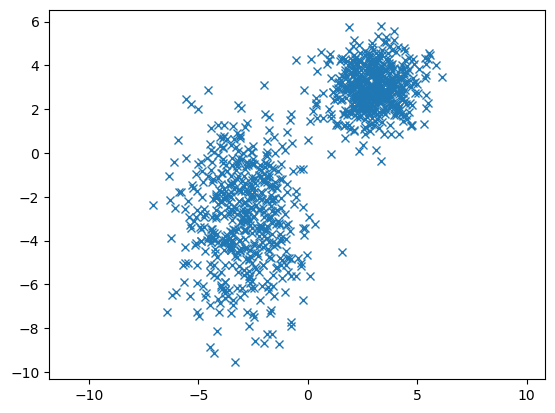

array([[ 2,  4,  2, ..., -3, -3,  4],
       [ 4,  4,  2, ..., -6,  0,  3],
       [ 1,  1,  1, ...,  2,  2,  1]])

In [48]:
# generate points
# import packages

import matplotlib . pyplot as plt 
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import math

mean= [3, 3]
cov = [[1, 0], [0, 1]]
a = np.random.multivariate_normal(mean, cov, 500).T

new_col = np.ones((1, a.shape[1]))
a = np.append(a, new_col, axis = 0)

mean= [-3, -3]
cov = [[2, 0], [0, 5]]
b = np.random.multivariate_normal(mean, cov, 500).T

new_col = np.full((1, b.shape[1]), 2)
b = np.append(b, new_col, axis = 0)

c = np.concatenate((a, b) , axis = 1) 
c=c.T
np.random. shuffle (c)
c=c.T

x = c[0] 
y=c[1]

plt.plot(x, y, "x") 
plt.axis("equal") 
plt .show()

# save and load data 
np.savetxt('testData.txt', c, fmt='%d')
d = np.loadtxt('testData.txt', dtype=int)
d


In [20]:
class KMeansClustering:

    # attributes
    k = None
    setWithDataTuples = None
    kDataPoinsInSet = None
    dictWithMappingAllPointsToK = None
    newKPointsinSet = None
    clusterCentroids = None
    clusterMemberships = None
    colourMap = None
    listOfColours = ["black", "green", "orange", "darkred", "darkblue", "lightblue", "purple", "pink", "cyan", "olive", "gray", "lightpink"]


    # constructor
    def __init__(self, setWithDataTuples, k):
        self.setWithDataTuples = setWithDataTuples
        self.k = k
        
    def __str__(self):
        return "K-Means Clustering Object" 
    


    # define all helper methods

    def __defineRandomKStart(self):
        # initiate list to store k random points
        kDataPointsInSet = set()
        # randomly draw k numbers in the rande of how long listWithDataTuples is
        rng = np.random.default_rng()
        randomPositionsOfKPoints = rng.integers(low=0, high=len(self.setWithDataTuples), size=self.k)
        # chose k points as random start points
        for i in randomPositionsOfKPoints:
            kDataPointsInSet.add(self.setWithDataTuples[i])
        
        # map colours to initial k points
        colourMap = {}
        number = 0
        for i in kDataPointsInSet:
            number += 1
            colourMap[i] = self.listOfColours[number]
        self.colourMap = colourMap
        
        return(kDataPointsInSet)
    


    def __mapAllPointsToNearestK(self, setOfKs):
        # calculate distance from each point to all k points
        dictWithMappingAllPointsToK = {}
        for k in setOfKs:
            dictWithMappingAllPointsToK[k] = []

        for i in self.setWithDataTuples:
            allDistancesFromOnePointToAllK = {}
            for l in setOfKs:
                allDistancesFromOnePointToAllK[l] = (self.__getEuclideanDistance(i[0], i[1], l[0], l[1]))
            # assign each point to the k-point which is closest
            # für minimales k:
            minK = min(allDistancesFromOnePointToAllK, key=allDistancesFromOnePointToAllK.get)
            dictWithMappingAllPointsToK[minK].append(i)

        return(dictWithMappingAllPointsToK)



    def __calcKNewMeans(self, dictWithMappingAllPointsToK):
        newKPointsinSet = set()
        for listWithPoints in dictWithMappingAllPointsToK.values():
            newMeanXCoordinate = []
            newMeanYCoordinate = []
            for i in range(len(listWithPoints)):
                newMeanXCoordinate.append(listWithPoints[i][0])
                newMeanX = round(sum(newMeanXCoordinate)/len(newMeanXCoordinate), 6)
                newMeanYCoordinate.append(listWithPoints[i][1])
                newMeanY = round(sum(newMeanYCoordinate)/len(newMeanYCoordinate), 6)
            newKPointsinSet.add((newMeanX, newMeanY,))

        # map colours to new centroids (that are closest to old ones)
        self.__reassignColorsToCentroids(newKPointsinSet)
            
        
        return(newKPointsinSet)
    

    def __reassignColorsToCentroids(self, newCentroids):
        # Dictionary to store the updated color mapping
        newColorMapping = {}
        
        # Find closest new centroid for each old centroid and assign the same color
        usedNewCentroids = set()
        for oldCentroid in self.colourMap:
            closestNewCentroid = min(newCentroids, key=lambda newCentroid: self.__getEuclideanDistance(oldCentroid[0], oldCentroid[1], newCentroid[0], newCentroid[1]))
            newColorMapping[closestNewCentroid] = self.colourMap[oldCentroid]
            usedNewCentroids.add(closestNewCentroid)
        
        # Find remaining colors from old centroids (i.e., those not reused)
        remainingColors = set(self.colourMap.values()) - set(newColorMapping.values())
        
        # Find new centroids that haven't been assigned a color yet
        unusedNewCentroids = set(newCentroids) - usedNewCentroids
        
        # Assign remaining colors from old centroids to new centroids
        for newCentroid in unusedNewCentroids:
            if remainingColors:
                newColorMapping[newCentroid] = remainingColors.pop()
            else:
                # Fallback if no remaining colors (this shouldn't happen with enough colors)
                newColorMapping[newCentroid] = "gray"
        
        # Update the color mapping to the new centroids
        self.colourMap = newColorMapping
    





    # main functions

    def cluster(self):

        # arbitrarily choose k objects from D as the initial cluster centres
        kDataPointsInSet = self.__defineRandomKStart()

        # assign each object to the cluster to which the object is most similar and update cluster means until no change
        mappingOld = 1
        mappingEnd = 0
        while mappingOld != mappingEnd:
            mappingOld = self.__mapAllPointsToNearestK(kDataPointsInSet)
            kDataPointsInSet = self.__calcKNewMeans(mappingOld)
            mappingEnd = self.__mapAllPointsToNearestK(kDataPointsInSet)

            self.clusterCentroids = kDataPointsInSet
            self.clusterMemberships = mappingEnd
            self.visualize()

        return(kDataPointsInSet, mappingEnd)
    

    def visualize(self):

        listWithListsX = []
        listWithListsY = []

        for centroid in self.clusterCentroids:
            oneListWithX = []
            oneListWithY = []
            for x in self.clusterMemberships[centroid]:
                oneListWithX.append(x[0])
            for y in self.clusterMemberships[centroid]:
                oneListWithY.append(y[1])
            listWithListsX.append(oneListWithX)
            listWithListsY.append(oneListWithY)
        

        for i in range(len(listWithListsX)):   
            centroid = list(self.clusterCentroids)[i] 
            plt.plot(listWithListsX[i], listWithListsY[i], "o", color=self.colourMap[centroid])
        plt.show()



    # helper function: calculate euclidean distance with 2 coordinates of the train and two coordinates of the test data 
    ### todo: can I generalize the function to take in any input coordinate length?!
    @staticmethod
    def __getEuclideanDistance(trainData1Coordinate, trainData2Coordinate, testData1Coordinate, testData2Coordinate):
        distance = math.sqrt((trainData1Coordinate-testData1Coordinate)**2+(trainData2Coordinate-testData2Coordinate)**2)
        return(distance)
    

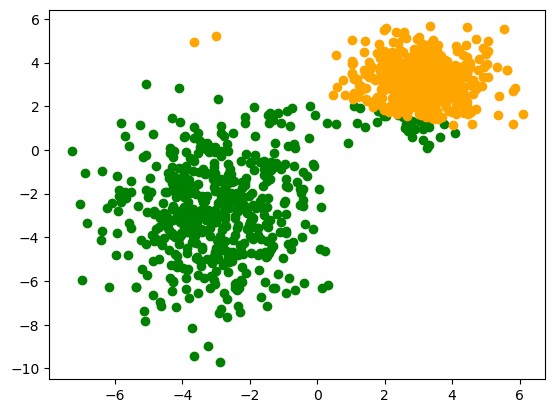

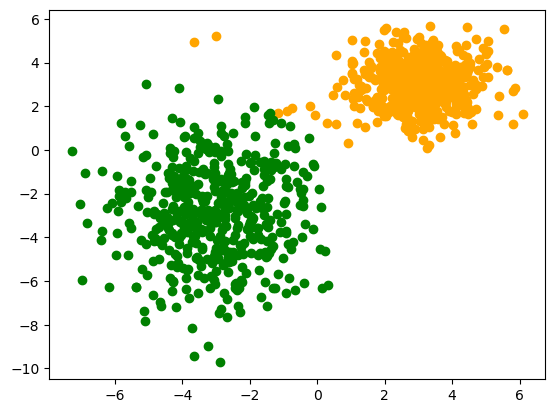

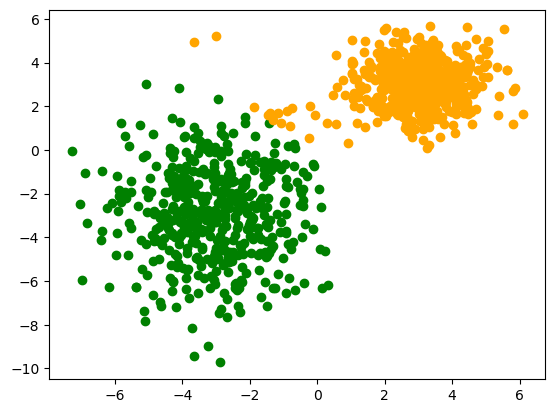

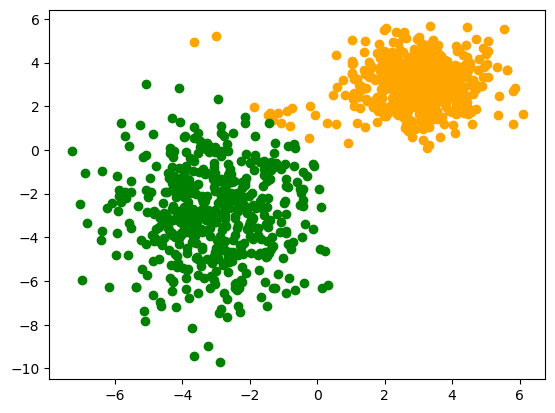

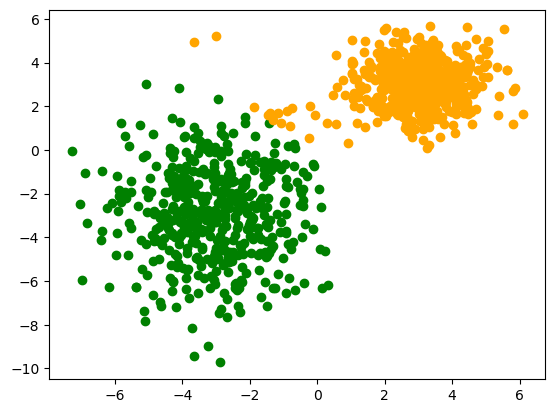

({(-3.095757, -2.9876), (2.91355, 3.005815)},
 {(-3.095757, -2.9876): [(-5.967993669028344, -4.815962205891925),
   (-4.193387602909823, -7.178835383671863),
   (-2.267863605692491, -0.4878615428160513),
   (-1.584053874522999, -0.879493602188882),
   (-2.427804081229976, -3.1141983969649667),
   (-4.016174239995958, -3.264243147031859),
   (-0.45162587615097705, -3.9695842186935755),
   (-4.059001409093602, -1.4920942044113772),
   (-2.364357198367339, -3.4359735492455714),
   (-3.4074050846286115, -4.535029475793432),
   (-2.8156493124673068, -1.8600201969967178),
   (-3.0938594809796114, -1.3170911665793854),
   (-0.41020281923224866, -2.586429588691072),
   (-4.148861427031306, -4.8671738234832755),
   (-3.808690144095187, -1.3619096809560238),
   (-2.3834792588796265, -6.392083304775262),
   (-3.7791043065503365, -3.35228596222084),
   (-2.62166634028758, -2.6582253292129394),
   (-3.8664110669936367, -4.727577202204838),
   (-3.584743493141909, -2.0165271026818488),
   (-2.347453

In [32]:
xy_tuples = list(zip(c[0], c[1]))
newModel = KMeansClustering(xy_tuples, 2)
newModel.cluster()

## Implement a simple version of K-Means

1. Start by choosing two random points in the dataset r1 and r2 and apply the following adaptation rule:

    for all x ∈ the dataset do
        if x is closer to r1 than to r2 then
            r1 ←(1−α)×r1 +α×x
        else if x is closer to r2 than to r1 then
            r2 ←(1−α)×r2 +α×x end if
    end for

2. Repeat for 10 times a passage through all the elements of the dataset (i.e. 10 epochs) with α = 10E − 5 and save:
    (i) the consecutive values of r1 and r2 for the first passage; 
    (ii) the values of r1 and r2 at the end of each passage.

3. Plot (i) and (ii) upon the dataset plot in different graphs. Change the value of α and the number of epochs to see the evolution of the representatives clearly. What do you conclude about the evolution of the two points in the different situations? Is there any relation between the final values of the representatives (r1 and r2) and the parameters used to generate the dataset?

4. Instead of changing the value of the representatives for each example, accumulate the values of the difference (x − r) and change the value only when all examples have been observed. Accumulate only for the closest representative in each iteration.
for all x do
d ← d + (x − r)
end for
r ← r + (α/n_examples) ∗ d

5. Plot the consecutive positions of r1 and r2 and compare with the plot in exercise 1.
What do you observe?

6. Plot with different colors:
• color 1 – points closer to r1 labeled 1; • color 2 – points closer to r1 labeled 2; • color 3 – points closer to r2 labeled 1; • color 4 – points closer to r2 labeled 2.
What do you observe?

7. Repeat the experiment 30 times and plot the final values of r1 and r2 over the dataset. If necessary amplify the viewed area to see the points’ distributions.

# Exercise 2

Implement a simplified version of agglomerative hierarchical clustering, as proposed in the following algorithm.
while there are more than two points do Find the closest two points
Replace both points by their average
end while
Test it on sets of points similar to the ones of the last exercise.


# Exercise 3

Implement the DBScan algorithm as described in https://www.youtube.com/watch?v=_A9Tq6mGtLI and demonstrate graphically the process with a series of snapshots of the process at key points with adequate descriptions.